# LeNet and FCLeNet Classifiers

## Loading and pre-processing MNIST

In [1]:
# -*- coding: utf-8 -*-
# The below is for auto-reloading external modules after they are changed, such as those in ./utils.
# Issue: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_utils import get_mnist
import torch

# Constants
DATA_DIR = 'mnist'
SEED = 111111

# If datasets are not at specified location, they will be downloaded.
train_imgs, train_lbls = get_mnist(data_dir=DATA_DIR, train=True, download=False)
test_imgs, test_lbls = get_mnist(data_dir=DATA_DIR, train=False, download=False)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('Class labels in train = ', np.unique(train_lbls))

C_classes = len(np.unique(train_lbls)) # C hereafter

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (60000, 28, 28) || Data type:  uint8
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (60000,) || Data type:  int16
Class labels in train =  [0 1 2 3 4 5 6 7 8 9]


In [2]:
# Change representation of labels to one-hot vectors of length C=10.
train_lbls_onehot = np.zeros(shape=(train_lbls.shape[0], C_classes ) )
train_lbls_onehot[ np.arange(train_lbls_onehot.shape[0]), train_lbls ] = 1
test_lbls_onehot = np.zeros(shape=(test_lbls.shape[0], C_classes ) )
test_lbls_onehot[ np.arange(test_lbls_onehot.shape[0]), test_lbls ] = 1
print("BEFORE: [train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("AFTER : [train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )

BEFORE: [train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (60000,)  || Data type:  int16
AFTER : [train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (60000, 10)  || Data type:  float64


In [3]:
# (Same as in Tut. 3)  
# Normalize intensities (from 0-255) to have 0-mean and 1-stdev. 
from utils.data_utils import normalize_int_whole_database
train_imgs = normalize_int_whole_database(train_imgs)
test_imgs = normalize_int_whole_database(test_imgs)

# Cross entropy for Classifier

In [4]:
def cross_entropy(y_pred, y_real, eps=1e-7):
    # y_pred: Tensor of shape [N, D_out]. Predicted class-posterior probabilities from forward.
    # y_real: Same shape as y_pred. One-hot representation of real labels.
    x_entr_per_sample = - torch.sum( y_real*torch.log(y_pred+eps), dim=1) # Sum over classes, axis=1
    loss = torch.mean(x_entr_per_sample, dim=0) # Expectation of loss: Mean over samples (axis=0).
    return loss

# Stochastic Gradient Descent

In [5]:
from utils.plotting import plot_train_progress, display_image_dynamically
import scipy.misc

def compute_accuracy(lbls_pred, lbls_real):
    # lbls_pred, lbls_read: np.arrays of labels (after argmax), not probabilities/onehot.
    acc = np.mean(lbls_pred == lbls_real) * 100.
    return acc

def get_random_batch(train_imgs, train_lbls, N_batch_size, rng):
    # train_imgs: Images for training. Numpy array of shape [S, H, W]
    # train_lbls: Labels of the training images.
    # N_batch_size: integer. Size that the batch should have.
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=N_batch_size, dtype='int32')
    train_imgs_batch = train_imgs[indices]
    train_lbls_batch = train_lbls[indices]
    return [train_imgs_batch, train_lbls_batch]

def gradient_descent(net, loss_func, grad_descent_optimizer, rng,
                     train_imgs, train_lbls, test_imgs, test_lbls,
                     N_batch_size, total_iters, iters_per_test=-1,
                     is_tumor_segm=False ):
    # net: Instance of a model.
    # loss_func: Function that computes the loss. See functions: cross_entropy.
    # grad_descent_optimizer: From torch.optim (see Task 2)
    # rng: numpy random number generator
    # train_imgs: The training images. Numpy array, shape [S_tr, H, W]
    # test_imgs: Save as above, for testing images. [S_te, H, W]
    # train_lbls: One hot representation of labels corresponding to train_imgs. Numpy array, shape [S_tr, C]
    # test_lbls: As above, but for testing data. [S_te, C]
    # N_batch_size: Size N of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many iterations in total to perform.
    # iters_per_test: Integer. Every that many iterations the model predicts the test data and accuracy is reported.
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}
    
    for t in range(total_iters):
        
        x, y_real = get_random_batch(train_imgs, train_lbls, N_batch_size, rng)
        
        y_pred = net.forward( torch.tensor(x, dtype=torch.float) )
        
        loss = loss_func(y_pred, torch.tensor(y_real, dtype=torch.float)) # Cross Entropy

        loss.backward() # Computes grads with auto-differentiation. Stores them in each params.grads
        
        # Update weights with gradient descent. One of optimizers given by torch.optim
        grad_descent_optimizer.step()
        grad_descent_optimizer.zero_grad()  # zero the parameter gradients.
        
        # ==== Report training loss and accuracy ======
        lbls_pred = np.argmax(y_pred.detach().numpy(), axis=1) # Get labels from the probabilities.
        lbls_real = np.argmax(y_real, axis=1) # Get labels from one-hot
        acc_train = compute_accuracy(lbls_pred, lbls_real)
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss.item()), "\t Accuracy: {0:.2f}".format(acc_train))
        
        # =============== Every few iterations, predict the testing-database ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            y_pred_test = net.forward(torch.tensor(test_imgs, dtype=torch.float))
            y_pred_test_numpy = y_pred_test.detach().numpy()
            # ==== Report test accuracy ======
            lbls_pred_test = np.argmax(y_pred_test_numpy, axis=1)
            lbls_real_test = np.argmax(test_lbls, axis=1)
            acc_test = compute_accuracy(lbls_pred_test, lbls_real_test)
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))
            
            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss.item())
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
            
            if is_tumor_segm:
                display_image_dynamically(y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_prob.png', y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_segm.png', lbls_pred_test[0,:,:])
                
                
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)
    



# Task 1: Build LeNet

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Docs of nn.Conv2d and nn.Linear and max_pool2d:
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear
# https://pytorch.org/docs/stable/nn.html#torch.nn.functional.max_pool2d

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        ######################### Build LeNet ########################
        # Make the above architecture of LeNet.
        # bias=True makes the layer create a bias internally. Nice and clean.
        # Conv2d gets args: (num input channs, num out channs, kernel_size ...)
        # Linear gets args: (num input neurons, num out neurons, ...)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0) # Params are initialized internally.
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=True) # nn.Linear is a fully connected layer.
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.fc3 = nn.Linear(84, num_classes, bias=True)
        # All parameters of a nn.Module are afterwards accessible by self.parameters()
        # Each layer's weights and biases are accessible by eg by self.conv1.weight & self.conv1.bias
    
    def forward(self, x):
        # x: Input tensor (batch of images) of shape [N, Channels, H, W]
        # returns: tensor of shape [N, classes]. The class posterior probabilities.
        # Make the forward pass.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, 10]
        ####################################################################
        return y_pred


# Task 2: Train LeNet classifier

train_imgs_cnn.shape should be (60000, 1, 32, 32). It is:  (60000, 1, 32, 32)
[iter: 0 ]: Training Loss: 2.30 	 Accuracy: 13.75
								 Testing Accuracy: 10.42
[iter: 1 ]: Training Loss: 2.32 	 Accuracy: 11.25
[iter: 2 ]: Training Loss: 2.30 	 Accuracy: 6.25
[iter: 3 ]: Training Loss: 2.31 	 Accuracy: 11.25
[iter: 4 ]: Training Loss: 2.31 	 Accuracy: 7.50
[iter: 5 ]: Training Loss: 2.29 	 Accuracy: 16.25
[iter: 6 ]: Training Loss: 2.30 	 Accuracy: 6.25
[iter: 7 ]: Training Loss: 2.30 	 Accuracy: 10.00
[iter: 8 ]: Training Loss: 2.30 	 Accuracy: 10.00
[iter: 9 ]: Training Loss: 2.30 	 Accuracy: 8.75
[iter: 10 ]: Training Loss: 2.31 	 Accuracy: 8.75
[iter: 11 ]: Training Loss: 2.29 	 Accuracy: 12.50
[iter: 12 ]: Training Loss: 2.31 	 Accuracy: 15.00
[iter: 13 ]: Training Loss: 2.29 	 Accuracy: 18.75
[iter: 14 ]: Training Loss: 2.29 	 Accuracy: 15.00
[iter: 15 ]: Training Loss: 2.29 	 Accuracy: 10.00
[iter: 16 ]: Training Loss: 2.30 	 Accuracy: 13.75
[iter: 17 ]: Training Loss: 2.27 	 Ac

								 Testing Accuracy: 79.23
[iter: 161 ]: Training Loss: 0.65 	 Accuracy: 78.75
[iter: 162 ]: Training Loss: 0.80 	 Accuracy: 77.50
[iter: 163 ]: Training Loss: 0.53 	 Accuracy: 86.25
[iter: 164 ]: Training Loss: 0.54 	 Accuracy: 83.75
[iter: 165 ]: Training Loss: 0.41 	 Accuracy: 91.25
[iter: 166 ]: Training Loss: 0.61 	 Accuracy: 82.50
[iter: 167 ]: Training Loss: 0.44 	 Accuracy: 87.50
[iter: 168 ]: Training Loss: 0.51 	 Accuracy: 82.50
[iter: 169 ]: Training Loss: 0.56 	 Accuracy: 91.25
[iter: 170 ]: Training Loss: 0.47 	 Accuracy: 83.75
[iter: 171 ]: Training Loss: 0.51 	 Accuracy: 85.00
[iter: 172 ]: Training Loss: 0.58 	 Accuracy: 82.50
[iter: 173 ]: Training Loss: 0.43 	 Accuracy: 90.00
[iter: 174 ]: Training Loss: 0.49 	 Accuracy: 83.75
[iter: 175 ]: Training Loss: 0.60 	 Accuracy: 77.50
[iter: 176 ]: Training Loss: 0.56 	 Accuracy: 80.00
[iter: 177 ]: Training Loss: 0.62 	 Accuracy: 77.50
[iter: 178 ]: Training Loss: 0.70 	 Accuracy: 75.00
[iter: 179 ]: Training Loss: 0.

								 Testing Accuracy: 92.79
[iter: 321 ]: Training Loss: 0.22 	 Accuracy: 91.25
[iter: 322 ]: Training Loss: 0.21 	 Accuracy: 92.50
[iter: 323 ]: Training Loss: 0.19 	 Accuracy: 95.00
[iter: 324 ]: Training Loss: 0.19 	 Accuracy: 95.00
[iter: 325 ]: Training Loss: 0.26 	 Accuracy: 92.50
[iter: 326 ]: Training Loss: 0.31 	 Accuracy: 86.25
[iter: 327 ]: Training Loss: 0.32 	 Accuracy: 88.75
[iter: 328 ]: Training Loss: 0.26 	 Accuracy: 93.75
[iter: 329 ]: Training Loss: 0.27 	 Accuracy: 92.50
[iter: 330 ]: Training Loss: 0.29 	 Accuracy: 96.25
[iter: 331 ]: Training Loss: 0.26 	 Accuracy: 91.25
[iter: 332 ]: Training Loss: 0.33 	 Accuracy: 92.50
[iter: 333 ]: Training Loss: 0.14 	 Accuracy: 98.75
[iter: 334 ]: Training Loss: 0.23 	 Accuracy: 90.00
[iter: 335 ]: Training Loss: 0.27 	 Accuracy: 91.25
[iter: 336 ]: Training Loss: 0.20 	 Accuracy: 92.50
[iter: 337 ]: Training Loss: 0.22 	 Accuracy: 91.25
[iter: 338 ]: Training Loss: 0.37 	 Accuracy: 90.00
[iter: 339 ]: Training Loss: 0.

								 Testing Accuracy: 94.54
[iter: 481 ]: Training Loss: 0.15 	 Accuracy: 95.00
[iter: 482 ]: Training Loss: 0.16 	 Accuracy: 93.75
[iter: 483 ]: Training Loss: 0.18 	 Accuracy: 95.00
[iter: 484 ]: Training Loss: 0.13 	 Accuracy: 96.25
[iter: 485 ]: Training Loss: 0.13 	 Accuracy: 96.25
[iter: 486 ]: Training Loss: 0.08 	 Accuracy: 98.75
[iter: 487 ]: Training Loss: 0.26 	 Accuracy: 92.50
[iter: 488 ]: Training Loss: 0.23 	 Accuracy: 96.25
[iter: 489 ]: Training Loss: 0.10 	 Accuracy: 97.50
[iter: 490 ]: Training Loss: 0.15 	 Accuracy: 93.75
[iter: 491 ]: Training Loss: 0.22 	 Accuracy: 91.25
[iter: 492 ]: Training Loss: 0.18 	 Accuracy: 92.50
[iter: 493 ]: Training Loss: 0.33 	 Accuracy: 91.25
[iter: 494 ]: Training Loss: 0.14 	 Accuracy: 97.50
[iter: 495 ]: Training Loss: 0.18 	 Accuracy: 93.75
[iter: 496 ]: Training Loss: 0.11 	 Accuracy: 97.50
[iter: 497 ]: Training Loss: 0.12 	 Accuracy: 96.25
[iter: 498 ]: Training Loss: 0.13 	 Accuracy: 97.50
[iter: 499 ]: Training Loss: 0.

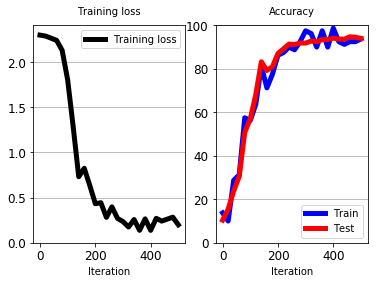

In [8]:
# Pytorch needs input to conv/pool to be of shape [N, Channels, H, W].
# For grayscale images, there is only 1 image channel. We add this *channels dimension*:
train_imgs_cnn = train_imgs.reshape([train_imgs.shape[0], 1, train_imgs.shape[1], train_imgs.shape[2]])
test_imgs_cnn = test_imgs.reshape([test_imgs.shape[0], 1, test_imgs.shape[1], test_imgs.shape[2]])

################ Pad images to fit to LeNet correctly ###################
# MNIST is 28x28 images. LeNet **by construction** requires images of shape 32x32 !
# with 2 voxels before and after H & W dimensions, to make them 32x32!
train_imgs_cnn = np.pad(train_imgs_cnn, ((0,0), (0,0), (2,2), (2,2)), mode='edge')
test_imgs_cnn = np.pad(test_imgs_cnn, ((0,0), (0,0), (2,2), (2,2)), mode='edge')
print("train_imgs_cnn.shape should be (60000, 1, 32, 32). It is: ", train_imgs_cnn.shape)
###############################################################################

# Create the network.
lenet = LeNet(num_classes=C_classes)

############## NOTE: Pytorch's optimizers (nothing to do here) #################
# Last time we wrote our own function for optimizing weights: w'=w-lr*grads.
# There are more complex ones (RMSProp, Adam, etc)
# Pytorch provides out-of-the-box optimizers that do this, so we dont need to write them.
# Create one, then call optimizer.step() & optimizer.zero_grad(). See SGD function above.
import torch.optim as optim
grad_descent_optimizer = optim.SGD(lenet.parameters(), lr=0.03, momentum=0.0)
################################################################################

# Start training
rng = np.random.RandomState(seed=SEED) # Random number generator
gradient_descent(lenet,
                 cross_entropy,
                 grad_descent_optimizer,
                 rng,
                 train_imgs_cnn,
                 train_lbls_onehot,
                 test_imgs_cnn,
                 test_lbls_onehot,
                 N_batch_size=80,
                 total_iters=500,
                 iters_per_test=20,
                 is_tumor_segm=False)


If done correctly, accuracy should reach between 90-95% both on training and testing samples.  
You should see a pretty plot at the bottom of the output when process finishes.

# Task 3: Build Fully Convolutional LeNet

Fully convolutional networks are networks that do not have dense/fully-connected layers. Any network with dense layers has an **exactly equivalent** fully-convolutional architecture. A dense layer can be turned to a convolution with mathematically exact same behaviour.

Explanation:
- Assume **input X** to a dense layer is a matrix of shape **(num_in_channs, height, width)**, which is the output from a previous conv layer that has (num_inp_channs) **feature maps**, each of **dimensions** \[height, width\].  
- A dense layer with (num-out) neurons has **weight matrix W** of shape: \[num-out, num-in-channs * height * width\].  
- **Each of the output neurons** in a dense layer has (num_inp_channs * height_of_inp * width_of_inp) weights connecting it to the above input.  
- Out of these, there are (height*width) weights connecting each output neuron to each input feature map. Each of these weights is different.
- Thus the above (height*width) weights can be seen as a kernel of shape \[height, width\].
- The weights connecting each output neuron to all input feature maps can be seen as a convolutional kernel of shape \[1, num_in_channs, height, width\].
- The whole weight matrix W can be reorganized as a convolution kernel \[out_channs, num_in_channs, height, width\]
- The whole **dense layer with num-out-neurons** can be reorganized as a **convolutional layer with num-out feature-maps**, where **ach output feature-map gives only 1 activation** (is of height=1 and width=1). 
- The operation applied by a dense layer, **dot_product(X,W)**, can be now cast as a **convolution(X,W_reorganized)**, with the two being **mathematically equivallent**.  

(Note: Won't be needed here, but in some implementations of conv/cross-correlation, you would need to flip the kernel. Check difference between conv and cross-correlation.)

Below, we are going to build a Fully Convolutional LeNet, that corresponds exactly to the previous LeNet...

In [9]:
class FCLeNet(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet, self).__init__()
        ################ Build a Fully Convolutional LeNet ####################
        # Adjust LeNet's code, and replace all nn.Linear layers with appropriate nn.Conv2d
        # Conv2d gets args: (num input channs, num out channs, kernel_size ...)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv2d(120, 84, kernel_size=1, bias=True, padding=0)
        self.conv5 = nn.Conv2d(84, num_classes, kernel_size=1, bias=True, padding=0)
        
    def forward(self, x):
        # x: Input tensor (batch of images) of shape [N, Channels, H, W]
        # returns: tensor of shape [N, classes] if input is of shape 32x32...
        # ... or Tensor of shape [N, classes, H_out, W_out if input >= 36x36.
        # Make the forward pass.
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, 10, 1, 1]
        #############################################################################
        
        # The output of LeNet was [N, 10] for input x of size 32x32.
        # y_pred here will be [N,10,1,1] if input x of size 32x32, ...
        # ... Or of shape [N, 10, H_out, W_out] if input larger than 32x32 is given.
        # If shape is [N,10,1,1], drop unary dimensions to have same behaviour as LeNet.
        if y_pred.shape[2] == 1 and y_pred.shape[3] == 1:
            y_pred = y_pred.reshape([y_pred.shape[0], y_pred.shape[1]])
            
        return y_pred

We above hopefully created a Fully Convolutional LeNet that we claimed can be mathematically equivalent to a LeNet with dense layers. Is it? Lets check...

Below, we will **transfer parameters** of the **pre-trained** LeNet (from Task 2) to FCLeNet, after we **reorganize them in convolutional kernels** of appropriate shape.

Then, we will apply both LeNet and FCLeNet, to check if we get the same result...

In [10]:
def transfer_weights_from_LeNet_to_FCLeNet(lenet, fclenet):
    # Docs on conv and linear layers, to see their .weight and .bias attributes:
    # https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d
    # https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear

    
    ############# Complete the below #######################################
    # Match which layer of lenet should be transfered to which of FCLeNet.
    # Reshape the weights of dense layers of LeNet to the shape needed by the convs.
    
    # Shape of weights : conv [out channels, in channels, kh, kw] linear: [out ch, in ch]
    # Shape of biases: conv & linear have same shape: [out channels]
    # NOTE: Shape of conv.weight is switched in comparison to how declared in nn.Conv2d(...) above.
    # ... Here, [out_chans, in_chans, H, W]. Above at nn.Conv2d(in_chans, out_chans, H, W)
    fclenet.conv1.weight.data = lenet.conv1.weight.data.clone()
    fclenet.conv1.bias.data = lenet.conv1.bias.data.clone()
    fclenet.conv2.weight.data = lenet.conv2.weight.data.clone()
    fclenet.conv2.bias.data = lenet.conv2.bias.data.clone()
    fclenet.conv3.weight.data = lenet.fc1.weight.data.clone().reshape([120,16,5,5])
    fclenet.conv3.bias.data = lenet.fc1.bias.data.clone()
    fclenet.conv4.weight.data = lenet.fc2.weight.data.clone().reshape([84,120,1,1])
    fclenet.conv4.bias.data = lenet.fc2.bias.data.clone()
    fclenet.conv5.weight.data = lenet.fc3.weight.data.clone().reshape([-1,84,1,1])
    fclenet.conv5.bias.data = lenet.fc3.bias.data.clone()
    ##################################################################################
    
# Initialize an FCLeNet, and then transfer the weights from pre-trained LeNet to FCLeNet.
fclenet = FCLeNet(num_classes=C_classes)
transfer_weights_from_LeNet_to_FCLeNet(lenet, fclenet)

# Test with LeNet
y_pred_lenet = lenet.forward(torch.tensor(test_imgs_cnn, dtype=torch.float))
lbls_pred_lenet = np.argmax(y_pred_lenet.detach().numpy(), axis=1)
acc_lenet = compute_accuracy(lbls_pred_lenet, test_lbls)
# Test with FCLeNet
y_pred_fclenet = fclenet.forward(torch.tensor(test_imgs_cnn, dtype=torch.float))
lbls_pred_fclenet = np.argmax(y_pred_fclenet.detach().numpy(), axis=1)
acc_fclenet = compute_accuracy(lbls_pred_fclenet, test_lbls)

print("Accuracy of LeNet {0:.2f}".format(acc_lenet), " and FCLeNet {0:.2f}".format(acc_fclenet))


Accuracy of LeNet 93.99  and FCLeNet 93.99


If done correctly, you should get **exactly** the same result from LeNet and FCLeNet.  
It should also be the same as the final test-accuracy when training LeNet above.

# Task 4: Beyond classification with Fully Conv. Nets

If we convert a fully connected layer to a conv layer appropriately, we get the same output. What's useful about it then?

*As all operations are convolutional, the network can receive input larger than its receptive field.*  

LeNet had to receive 32x32 size of input by construction, and would return 1 output.
We say that it has a **receptive field** of size 32x32 by construction. *Size of receptive field* is how many pixels the net processes for its output neurons to give one output activation (prediction). The size of the receptive field is defined by the size of the kernels, their strides, and the numbers of layers.

FCLeNet has exactly the same size of receptive field with LeNet, since as we saw the two architectures are equivalent. It processes 32x32 pixels via convs and pools, and gives one output. But...  

... As whole FCLeNet is made of kernels convolving an output (pooling is the same), nothing stops it from receiving a larger input. If given an input larger than 32x32, kernels at each layer will be applied as normally, they will simply output more activations at the output feature maps. All feature maps will expand, *including the output feature maps*, that used to be 1x1 for 32x32 input, which will give more than one prediction.

Lets see this in practice...

Plotting image of shape:  (32, 32)
For input of shape: (1, 1, 32, 32)  FCLeNet gave output of shape  (1, 10)
Predicted class posterior probabilities: [[1.79849558e-05 1.33418525e-05 4.53814660e-04 2.22237959e-05
  9.85119045e-01 3.84251005e-04 1.01556745e-03 1.47342158e-04
  1.91403684e-04 1.26350364e-02]]
Predicted class (argmax) is: [4]


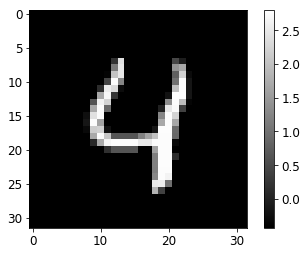

In [13]:
from utils.plotting import plot_image
# Choose an index of an image to test on...
index_of_img = 4
image_for_cnn = test_imgs_cnn[ index_of_img : index_of_img+1, :, :, : ] # [1, 1, 32, 32]
real_lbl = test_lbls[index_of_img]
plot_image(image_for_cnn[0,0,:,:], cmap="gray")

######### Run inference on the ORIGINAL 32x32 image. ###################
# Do a forward pass with fclenet
pred_probs = fclenet.forward( torch.tensor(image_for_cnn, dtype=torch.float) ) # Outp shape: [1, 10]
pred_probs = pred_probs.detach().numpy() # make tensor numpy
pred_lbls = np.argmax(pred_probs, axis=1) # Shape: [1]
#############################################################################
print("For input of shape:", image_for_cnn.shape, " FCLeNet gave output of shape ", pred_probs.shape)
print("Predicted class posterior probabilities:", pred_probs)
print("Predicted class (argmax) is:", pred_lbls)


image_for_cnn_padded.shape : (1, 1, 64, 64)
Plotting image of shape:  (64, 64)


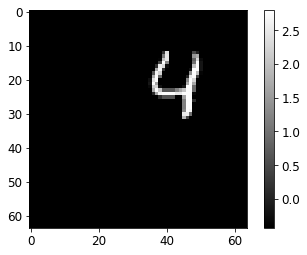

In [24]:
# Now make a larger image to apply FCLeNet on...
# Pad the 32x32 image in the H and W dimension enough to become 64 x 64
image_for_cnn_padded = np.pad(image_for_cnn, ((0,0),(0,0),(5,27),(27,5)), mode='edge')
print("image_for_cnn_padded.shape :", image_for_cnn_padded.shape)
plot_image(image_for_cnn_padded[0,0,:,:])

For input of shape: (1, 1, 64, 64)  FCLeNet gave output of shape: (1, 10, 9, 9)
Plotting output of Channel # 4 (real class) of the last conv layer (classification layer):
Plotting image of shape:  (9, 9)


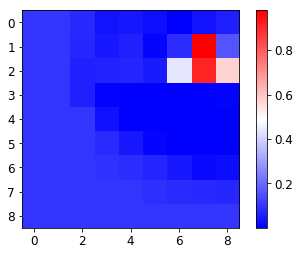

In [15]:
######### Run inference with FCLeNet on the padded 64 x 64 image.  ###############
pred_probs_padded = fclenet.forward( torch.tensor(image_for_cnn_padded, dtype=torch.float) ) # shape: [1, 10, H_out, W_out]
pred_probs_padded = pred_probs_padded.detach().numpy() # make tensor numpy
pred_lbls_padded = np.argmax(pred_probs_padded, axis=1) # Shape: [1, H_out, W_out]
########################################################################################
print("For input of shape:", image_for_cnn_padded.shape, " FCLeNet gave output of shape:", pred_probs_padded.shape)
print("Plotting output of Channel #", real_lbl, "(real class) of the last conv layer (classification layer):")
plot_image(pred_probs_padded[0,real_lbl,:,:], cmap="bwr")

For a 64 x 64 input, FCLeNet.forward() should output a \[1,10,9,9\] matrix. For each of the 10 classes, it outputs a *probability map* of size \[9,9\] (the feature map output by the last conv). Above you should see plotted the probability map for the *real* class of the digit in the input.

# Task 5: Upsample the output to the original resolution

Comparing the output with the padded 64x64 image, it looks as if the network **localizes** the digit in the image. But the output is in low resolution. Why? Because of the x4 downsampling done inside the network by the 2 pooling layers (each downsamples x2).

Lets **upsample** it back to original resolution with **interpolation**.
- **Repeat elements x4** in the spatial dimensions (H,W).  
- Then **convolve with a uniform kernel** in the spatial dimensions (H,W).

Plotting image after repetition....................
Plotting image of shape:  (36, 36)
Upsampled image after repetition has shape: (1, 10, 36, 36)
Plotting image after convolution...................
Plotting image of shape:  (33, 33)
Upsampled image after convolution has shape: (1, 10, 33, 33)


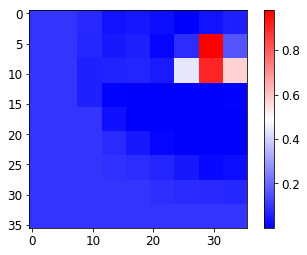

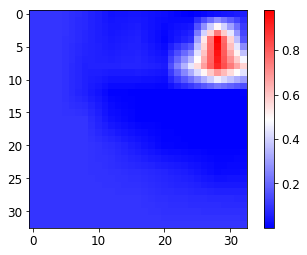

In [18]:
from scipy import signal

############# Repeat elements x4 along the two spatial dimensions #####################
pred_probs_padded_ups = np.repeat(pred_probs_padded, repeats=4, axis=2) # [N,Class,H,W]
pred_probs_padded_ups = np.repeat(pred_probs_padded_ups, repeats=4, axis=3)
print("Plotting image after repetition....................")
plot_image(pred_probs_padded_ups[0,real_lbl,:,:], cmap="bwr")
print("Upsampled image after repetition has shape:", pred_probs_padded_ups.shape) # (1, 10, 33, 33)
############################################################################################
# Convolve with uniform kernel:
kernel = np.ones([1,1,4,4])/16.
pred_probs_padded_ups = signal.convolve(pred_probs_padded_ups, kernel, mode='valid')
print("Plotting image after convolution...................")
plot_image(pred_probs_padded_ups[0,4], cmap="bwr")

print("Upsampled image after convolution has shape:", pred_probs_padded_ups.shape) # (1, 10, 33, 33)

If done right, you will notice it looks like a very good localisation of the digit.

Notice the shape of the upsampled image. It should be 33x33.  
- The initial 9x9 voxels were repeated x4, up to 36x36.  
- The convolution with mode='valid' requires that the kernel is fully contained in the image for a response.  
- Thus, convolving a 36x36 image with a 4x4 kernel gives 33x33 responses.  
- The whole process can be seen as if we interpolated 3 voxels in between each of the original 9x9 voxels.

*Each 'valid' convolution with kernel of size k reduces the shape of the input by k-1.*  
**Why do we care?** Because this is what happens within the neural network as well with every conv/pool.  

**Eventhough we upsampled, the output is not same size as the original input, 64x64. Why?**  
Exactly because of the above behaviour of the **'valid' convolutions within the net (and pools with ceiling=True)**.  
With every conv or pool with kernel of size k, the feature maps get reduced in size by (k-1). **Except** if we use **padding=True** in the net, though this may cause problems for segmentation. 
Padding was quite irrelevant for classification nets, but becomes important for segmentation.